In [1]:
from collections import defaultdict

import gymnasium
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
from torch import nn
from tensordict.nn import TensorDictModule
import numpy as np

In [2]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter, ActionMask, TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, MaskedCategorical, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE

In [3]:
from env import BattleshipEnv
gymnasium.register(
    id="Battleship-v0",
    entry_point=BattleshipEnv,
)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
base_env = GymEnv("Battleship-v0", categorical_action_encoding=True, device=device)

In [6]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        # ObservationNorm(in_keys=["observation"]),
        ActionMask(mask_key='mask'),
        DoubleToFloat(),
        StepCounter(),
    ),
)

In [7]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    mask: UnboundedDiscrete(
        shape=torch.Size([100]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([100]), device=cuda:0, dtype=torch.bool, contiguous=True),
            high=Tensor(shape=torch.Size([100]), device=cuda:0, dtype=torch.bool, contiguous=True)),
        device=cuda:0,
        dtype=torch.bool,
        domain=discrete),
    observation: BoundedContinuous(
        shape=torch.Size([4, 10, 10]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([4, 10, 10]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([4, 10, 10]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            

In [8]:
check_env_specs(env)

2025-05-23 03:21:07,973 [torchrl][INFO] check_env_specs succeeded!


In [9]:
rollout = env.rollout(50)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([50]), device=cuda:0, dtype=torch.int64, is_shared=True),
        done: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        mask: Tensor(shape=torch.Size([50, 100]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                mask: Tensor(shape=torch.Size([50, 100]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([50, 4, 10, 10]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([50, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch

In [10]:
class CNN(nn.Module):
    def __init__(self, in_channels=4, n_actions=100):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ZeroPad2d(2),
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=4, padding='same'),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),  # Input is 64*5*5 = 1600
            nn.ReLU(),
            nn.Linear(256, n_actions)  # Output layer, no activation for Q-values
        )

    def forward(self, x):
        if x.dim() != 4:
            x = x.unsqueeze(0)

        x = self.conv(x)
        # print(x.shape, x)
        # x = x.view(x.size(0), -1)
        x = x.flatten(start_dim=1)
        # print(x.shape, x)
        x = self.head(x)

        # print(x.shape)
        # if x.shape[0] == 1:
        #     return x.squeeze()
        return x

In [132]:
actor_net = CNN()
actor_net.to(device)

CNN(
  (conv): Sequential(
    (0): ZeroPad2d((2, 2, 2, 2))
    (1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (7): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=1600, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [133]:
policy_module_base = TensorDictModule(
    actor_net, in_keys=['observation'], out_keys=['logits']
)

In [134]:
policy_module = ProbabilisticActor(
    module=policy_module_base,
    spec=env.action_spec,
    in_keys=["logits", 'mask'],
    distribution_class=MaskedCategorical,
    return_log_prob=True,
)

In [124]:
rollout = env.rollout(max_steps=1, policy=policy_module)

In [135]:
value_net = CNN(n_actions=1).to(device)

In [136]:
value_module = ValueOperator(
    module=value_net,
    in_keys=['observation'],
)

In [137]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        logits: Tensor(shape=torch.Size([1, 100]), device=cuda:0, dtype=torch.float32, is_shared=True),
        mask: Tensor(shape=torch.Size([100]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([4, 10, 10]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:

In [138]:
frames_per_batch = 2000
total_frames = 1000000

In [139]:
collector = SyncDataCollector(
    env,
    policy=policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    # split_trajs=False,
    reset_when_done=True,
    reset_at_each_iter=True,
    device=device,
)

In [140]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [141]:
sub_batch_size = 64
num_epochs = 10
clip_epsilon = (
    0.2
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [142]:
lr = 3e-4
max_grad_norm = 1.0

In [143]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True, device=device,
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

In [145]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # print(i, tensordict_data)
    # print('hey')
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].float().mean().item())
    stepcount_str = f"step count (mean): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].float().mean().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()
    # print('okak')

eval cumulative reward:  126.0000 (init:  126.0000), eval step-count: 45.0, average reward= 1.2845 (init= 1.2280), step count (mean): 46.87900161743164, lr policy:  0.0003:   1%|          | 8000/1000000 [00:22<46:54, 352.46it/s]
eval cumulative reward:  117.0000 (init:  118.0000), eval step-count: 49.5, average reward= 1.2905 (init= 1.2815), step count (mean): 46.375003814697266, lr policy:  0.0000:  99%|█████████▉| 992000/1000000 [35:51<00:16, 475.56it/s]              

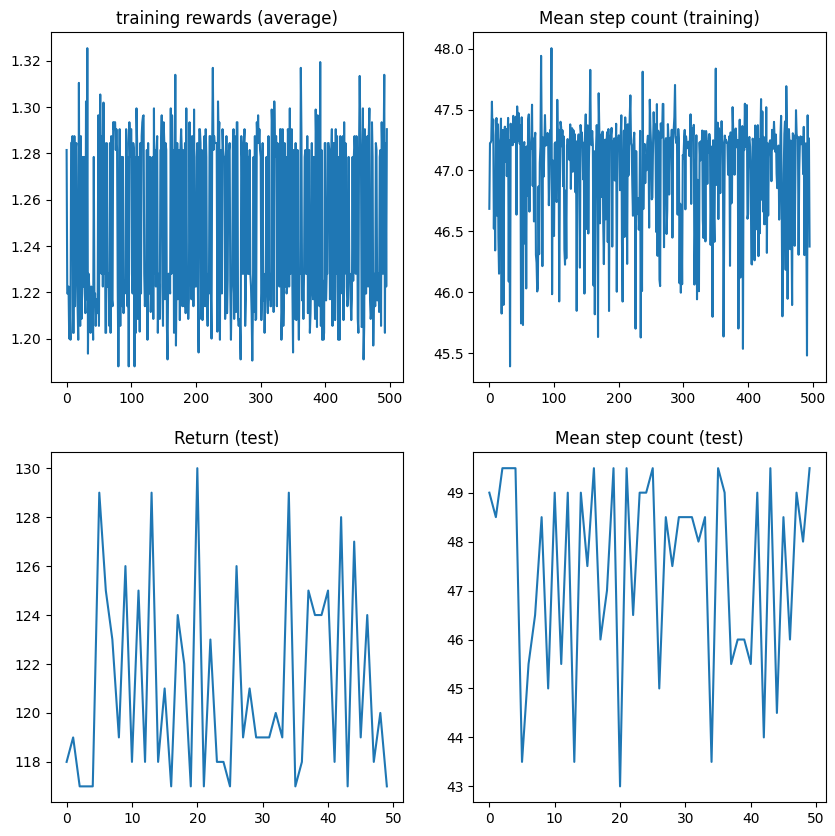

In [146]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Mean step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Mean step count (test)")
plt.show()

In [147]:
torch.save(actor_net.state_dict(), "checkpoints/ppo_1.pt")